## Import Packages

In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


## Read File

In [3]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]


## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [4]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [5]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'


## Data Classifier

In [6]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality


## Split dataset into x and y and one-hot encode quality column

In [7]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = OneHotEncoder().fit_transform(new_data[['quality']]).toarray()


## Train test split

In [9]:

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=10)


## Scale the data to Improve the speed of training Model

In [ ]:
!pip install matplotlib

range of the xTrain:
n_tokens_title                   2.000000e+01
n_tokens_content                 7.049000e+03
n_unique_tokens                  7.857646e-01
n_non_stop_words                 4.736500e-08
n_non_stop_unique_tokens         8.435013e-01
num_hrefs                        3.040000e+02
num_self_hrefs                   4.900000e+01
num_imgs                         1.000000e+02
num_videos                       7.400000e+01
average_token_length             4.441534e+00
num_keywords                     9.000000e+00
data_channel_is_lifestyle        1.000000e+00
data_channel_is_entertainment    1.000000e+00
data_channel_is_bus              1.000000e+00
data_channel_is_socmed           1.000000e+00
data_channel_is_tech             1.000000e+00
data_channel_is_world            1.000000e+00
kw_min_min                       3.780000e+02
kw_max_min                       4.010000e+04
kw_avg_min                       6.700167e+03
kw_min_max                       8.433000e+05
kw_max_max   

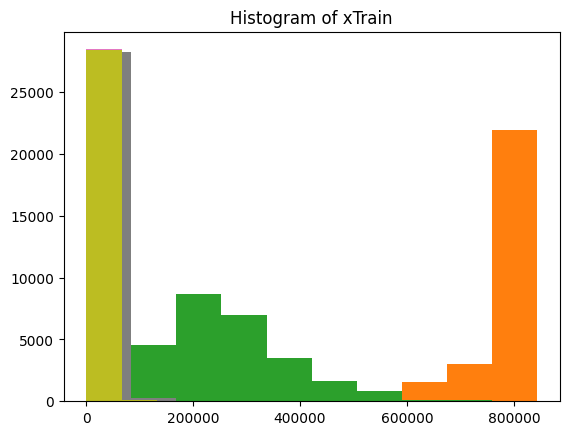

In [10]:

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


scaler = MinMaxScaler()
scale_xTrain = scaler.fit_transform(xTrain)
scale_xTest = scaler.transform(xTest)

print("range of the xTrain:")
print(xTrain.max() - xTrain.min())
for i in xTrain.columns:
    plt.hist(xTrain[i])
plt.title("Histogram of xTrain")
plt.show()



## Create and train model(NN)

In [11]:
def build_nn_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mirror_strategy = tf.distribute.MirroredStrategy()
with mirror_strategy.scope():
    nn_model1 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])
    nn_model2 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])

    fit_speed = tf.data.Dataset.from_tensor_slices((scale_xTrain, yTrain))
    fit_speed = fit_speed.repeat().batch(100)

    nn_model1.fit(scale_xTrain, yTrain, epochs=10)
    nn_model2.fit(scale_xTrain, yTrain, epochs=10)

Epoch 1/10
892/892 [==============================] - 11s 5ms/step - loss: 1.2246 - accuracy: 0.4288
Epoch 2/10
892/892 [==============================] - 4s 5ms/step - loss: 1.2042 - accuracy: 0.4419
Epoch 3/10
892/892 [==============================] - 5s 6ms/step - loss: 1.1957 - accuracy: 0.4456
Epoch 4/10
892/892 [==============================] - 4s 5ms/step - loss: 1.1901 - accuracy: 0.4515
Epoch 5/10
892/892 [==============================] - 4s 5ms/step - loss: 1.1845 - accuracy: 0.4538
Epoch 6/10
892/892 [==============================] - 5s 6ms/step - loss: 1.1796 - accuracy: 0.4553
Epoch 7/10
892/892 [==============================] - 4s 5ms/step - loss: 1.1762 - accuracy: 0.4576
Epoch 8/10
892/892 [==============================] - 6s 7ms/step - loss: 1.1713 - accuracy: 0.4584
Epoch 9/10
892/892 [==============================] - 4s 5ms/step - loss: 1.1682 - accuracy: 0.4633
Epoch 10/10
892/892 [==============================] - 4s 4ms/step - loss: 1.1636 - accuracy: 0.461

## Create and train model(Random Forest)

In [ ]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(scale_xTrain, yTrain.argmax(axis=1))


RandomForestClassifier()

## Make predictions with each model individually (NN and RF)

In [ ]:
nn1_train_pred = nn_model1.predict(scale_xTrain)
nn2_train_pred = nn_model2.predict(scale_xTrain)
RF_train_pred = RF_model.predict_proba(scale_xTrain)

nn1_test_pred = nn_model1.predict(scale_xTest)
nn2_test_pred = nn_model2.predict(scale_xTest)
RF_test_pred = RF_model.predict_proba(scale_xTest)

print("Shape:")
print("nn1_train_pred:", nn1_train_pred.shape)
print("nn2_train_pred:", nn2_train_pred.shape)
print("RF_train_pred:", RF_train_pred.shape)

nn1_train_labels = nn1_train_pred.argmax(axis=1)
nn2_train_labels = nn2_train_pred.argmax(axis=1)
RF_train_labels = RF_train_pred.argmax(axis=1)

nn1_test_labels = nn1_test_pred.argmax(axis=1)
nn2_test_labels = nn2_test_pred.argmax(axis=1)
RF_test_labels = RF_test_pred.argmax(axis=1)

print("Labels:")
print("nn1_train_pred:", nn1_train_labels)
print("nn2_train_pred:", nn2_train_labels)
print("RF_train_pred:", RF_train_labels)
print("nn1_test_pred:", nn1_test_labels)
print("nn2_test_pred:", nn2_test_labels)
print("RF_test_pred:", RF_test_labels)
print()

223/223 [==============================] - 1s 2ms/step
Shape:
nn1_train_pred: (28543, 4)
nn2_train_pred: (28543, 4)
RF_train_pred: (28543, 4)
Labels:
nn1_train_pred: [0 3 3 ... 3 3 0]
nn2_train_pred: [0 3 3 ... 3 3 3]
RF_train_pred: [3 3 0 ... 1 1 0]
nn1_test_pred: [3 1 1 ... 3 3 3]
nn2_test_pred: [1 1 1 ... 3 3 1]
RF_test_pred: [3 1 1 ... 1 3 1]



## Simple Ensemble: 3 linear models

## Train the 3 linear models

In [13]:
from sklearn.linear_model import Ridge
linmodel_1 = Ridge(alpha=0.01)
linmodel_2 = Ridge(alpha=0.3)
linmodel_3 = Ridge(alpha=0.5)

linmodel_1.fit(scale_xTrain, yTrain)
linmodel_2.fit(scale_xTrain, yTrain)
linmodel_3.fit(scale_xTrain, yTrain)

Ridge(alpha=0.5)

## Get the predictions out of the 3 linear regression models

In [ ]:
linmodel1_train_pred = linmodel_1.predict(scale_xTrain)
linmodel2_train_pred = linmodel_2.predict(scale_xTrain)
linmodel3_train_pred = linmodel_3.predict(scale_xTrain)

linmodel1_test_pred = linmodel_1.predict(scale_xTest)
linmodel2_test_pred = linmodel_2.predict(scale_xTest)
linmodel3_test_pred = linmodel_3.predict(scale_xTest)

## Get the ensemble prediction

In [ ]:
ensemble_simple_train_pred = (linmodel1_train_pred + linmodel2_train_pred + linmodel3_train_pred) / 3
ensemble_simple_test_pred = (linmodel1_test_pred + linmodel2_test_pred + linmodel3_test_pred) / 3

ensemble_simple_train_labels = ensemble_simple_train_pred.argmax(axis=1)
ensemble_simple_test_labels = ensemble_simple_test_pred.argmax(axis=1)

## (Simple Ensemble) Evaluation

In [ ]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_simple_train_labels, zero_division=0))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_simple_test_labels, zero_division=0))

Train:
              precision    recall  f1-score   support

           0       0.47      0.49      0.48      8329
           1       0.41      0.04      0.07      5709
           2       0.32      0.02      0.04      2879
           3       0.44      0.73      0.55     11626

    accuracy                           0.45     28543
   macro avg       0.41      0.32      0.29     28543
weighted avg       0.43      0.45      0.38     28543

Test:
              precision    recall  f1-score   support

           0       0.63      0.07      0.12      2103
           1       0.28      0.46      0.35      1420
           2       0.24      0.16      0.19       702
           3       0.42      0.59      0.49      2911

    accuracy                           0.37      7136
   macro avg       0.39      0.32      0.29      7136
weighted avg       0.44      0.37      0.32      7136



In [ ]:
from sklearn.metrics import accuracy_score

lin1_train_labels = linmodel1_train_pred.argmax(axis=1)
lin2_train_labels = linmodel2_train_pred.argmax(axis=1)
lin3_train_labels = linmodel3_train_pred.argmax(axis=1)

lin1_test_labels = linmodel1_test_pred.argmax(axis=1)
lin2_test_labels = linmodel2_test_pred.argmax(axis=1)
lin3_test_labels = linmodel3_test_pred.argmax(axis=1)

lin1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin1_train_labels)
lin2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin2_train_labels)
lin3_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin3_train_labels)

lin1_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin1_test_labels)
lin2_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin2_test_labels)
lin3_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin3_test_labels)

ensemble_simple_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_simple_train_labels)
ensemble_simple_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_simple_test_labels)

print("Model Train Accuracies:")
print(f"LR 1: {lin1_train_accuracy:.4f}")
print(f"LR 2: {lin2_train_accuracy:.4f}")
print(f"LR 3: {lin3_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"LR 1: {lin1_test_accuracy:.4f}")
print(f"LR 2: {lin2_test_accuracy:.4f}")
print(f"LR 3: {lin3_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_simple_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_simple_test_accuracy:.4f}")

if ensemble_simple_test_accuracy > ensemble_simple_train_accuracy:
    print("There could be overfitting.")
else:
    print("There should be no overfitting.")

Model Train Accuracies:
LR 1: 0.4494
LR 2: 0.4487
LR 3: 0.4451

Model Test Accuracies:
LR 1: 0.3104
LR 2: 0.3515
LR 3: 0.4183

Ensemble Model:
Training Accuracy: 0.4485
Testing Accuracy: 0.3672
There should be no overfitting.


## Medium Ensemble: 2 NN + 1 Linear

In [ ]:
ensemble_medium_train_pred = (nn1_train_pred + nn2_train_pred + linmodel1_train_pred) / 3
ensemble_medium_test_pred = (nn1_test_pred + nn2_test_pred + linmodel1_test_pred) / 3

ensemble_medium_train_labels = ensemble_medium_train_pred.argmax(axis=1)
ensemble_medium_test_labels = ensemble_medium_test_pred.argmax(axis=1)

## (Medium Ensemble) Evaluation

In [ ]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_medium_train_labels, zero_division=0))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_medium_test_labels, zero_division=0))

Train:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      8329
           1       0.48      0.13      0.20      5709
           2       0.37      0.04      0.07      2879
           3       0.45      0.70      0.55     11626

    accuracy                           0.47     28543
   macro avg       0.45      0.35      0.33     28543
weighted avg       0.46      0.47      0.42     28543

Test:
              precision    recall  f1-score   support

           0       0.61      0.12      0.20      2103
           1       0.31      0.41      0.35      1420
           2       0.25      0.20      0.22       702
           3       0.42      0.62      0.50      2911

    accuracy                           0.39      7136
   macro avg       0.40      0.34      0.32      7136
weighted avg       0.44      0.39      0.36      7136



In [ ]:
lin1_train_labels = linmodel1_train_pred.argmax(axis=1)
lin2_train_labels = linmodel2_train_pred.argmax(axis=1)

lin1_test_labels = linmodel1_test_pred.argmax(axis=1)
lin2_test_labels = linmodel2_test_pred.argmax(axis=1)

lin1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin1_train_labels)
lin2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin2_train_labels)
nn1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn1_train_labels)

lin1_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin1_test_labels)
lin2_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin2_test_labels)
nn1_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn1_test_labels)

ensemble_medium_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_medium_train_labels)
ensemble_medium_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_medium_test_labels)

print("Model Train Accuracies:")
print(f"LR 1: {lin1_train_accuracy:.4f}")
print(f"LR 2: {lin2_train_accuracy:.4f}")
print(f"NN : {nn1_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"LR 1: {lin1_test_accuracy:.4f}")
print(f"LR 2: {lin2_test_accuracy:.4f}")
print(f"NN : {nn1_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_medium_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_medium_test_accuracy:.4f}")

if ensemble_simple_test_accuracy > ensemble_simple_train_accuracy:
    print("There could be overfitting.")
else:
    print("There should be no overfitting.")

Model Train Accuracies:
LR 1: 0.4494
LR 2: 0.4487
NN : 0.4652

Model Test Accuracies:
LR 1: 0.3104
LR 2: 0.3515
NN : 0.4330

Ensemble Model:
Training Accuracy: 0.4674
Testing Accuracy: 0.3900
There should be no overfitting.


## Complex Ensemble: 2 NN + 1 RF

In [ ]:
ensemble_train_pred = (nn1_train_pred + nn2_train_pred + RF_train_pred) / 3
ensemble_test_pred = (nn1_test_pred + nn2_test_pred + RF_test_pred) / 3

ensemble_train_labels = ensemble_train_pred.argmax(axis=1)
ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

print("ensemble_train_labels:",ensemble_train_labels)
print("ensemble_train_labels:",ensemble_train_labels)


ensemble_train_labels: [3 3 0 ... 3 1 0]
ensemble_train_labels: [3 3 0 ... 3 1 0]


## Model Evaluation

In [ ]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_test_labels))


Train:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8329
           1       0.96      0.75      0.84      5709
           2       1.00      0.56      0.72      2879
           3       0.83      0.99      0.90     11626

    accuracy                           0.88     28543
   macro avg       0.92      0.80      0.84     28543
weighted avg       0.89      0.88      0.87     28543

Test:
              precision    recall  f1-score   support

           0       0.58      0.17      0.27      2103
           1       0.35      0.30      0.32      1420
           2       0.30      0.11      0.16       702
           3       0.42      0.73      0.53      2911

    accuracy                           0.42      7136
   macro avg       0.41      0.33      0.32      7136
weighted avg       0.44      0.42      0.38      7136



In [ ]:
nn1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn1_train_labels)
nn2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn2_train_labels)
RF_train_accuracy = accuracy_score(yTrain.argmax(axis=1), RF_train_labels)

nn1_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn1_test_labels)
nn2_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn2_test_labels)
RF_test_accuracy = accuracy_score(yTest.argmax(axis=1), RF_test_labels)

ensemble_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
ensemble_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)

print("Model Train Accuracies:")
print(f"Neural Network 1: {nn1_train_accuracy:.4f}")
print(f"Neural Network 2: {nn2_train_accuracy:.4f}")
print(f"Random Forest: {RF_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"Neural Network 1: {nn1_test_accuracy:.4f}")
print(f"Neural Network 2: {nn2_test_accuracy:.4f}")
print(f"Random Forest: {RF_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_test_accuracy:.4f}")

if ensemble_test_accuracy > ensemble_train_accuracy:
    print("There could be overfitting.")
else:
    print("There should be no overfitting.")

Model Train Accuracies:
Neural Network 1: 0.4652
Neural Network 2: 0.4660
Random Forest: 1.0000

Model Test Accuracies:
Neural Network 1: 0.4330
Neural Network 2: 0.4074
Random Forest: 0.4098

Ensemble Model:
Training Accuracy: 0.8760
Testing Accuracy: 0.4180
There should be no overfitting.


## Stratified KFold + Complex Ensemble Evaluation

In [14]:
from sklearn.model_selection import StratifiedKFold

# Initialize empty lists to store trained models
nn1_models, nn2_models, rf_models, ridge1_models, ridge2_models, ridge3_models = [], [], [], [], [], []

# Define StratifiedKFold instance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

mirror_strategy = tf.distribute.MirroredStrategy()

for train_index, test_index in skf.split(x, y.argmax(axis=1)):
    xTrain_fold, xTest_fold = x.iloc[train_index].values, x.iloc[test_index].values
    yTrain_fold, yTest_fold = y[train_index], y[test_index]

    # Scale data after splitting
    scaler = MinMaxScaler()
    xTrain_fold = scaler.fit_transform(xTrain_fold)
    xTest_fold = scaler.transform(xTest_fold)  # Important: transform only using the train data scaling parameters

    # Neural Network Training within the mirror_strategy scope
    with mirror_strategy.scope():
        nn_model1 = build_nn_model(xTrain_fold.shape[1:], yTrain_fold.shape[1])
        nn_model2 = build_nn_model(xTrain_fold.shape[1:], yTrain_fold.shape[1])

        nn_model1.fit(xTrain_fold, yTrain_fold, epochs=10, verbose=0)
        nn_model2.fit(xTrain_fold, yTrain_fold, epochs=10, verbose=0)

    # Random Forest Training
    RF_model = RandomForestClassifier(n_estimators=100)
    RF_model.fit(xTrain_fold, yTrain_fold.argmax(axis=1))

    # Ridge Regression Training
    linmodel_1 = Ridge(alpha=0.01)
    linmodel_2 = Ridge(alpha=0.3)
    linmodel_3 = Ridge(alpha=0.5)
    linmodel_1.fit(xTrain_fold, yTrain_fold)
    linmodel_2.fit(xTrain_fold, yTrain_fold)
    linmodel_3.fit(xTrain_fold, yTrain_fold)

    # Store trained models
    nn1_models.append(nn_model1)
    nn2_models.append(nn_model2)
    rf_models.append(RF_model)
    ridge1_models.append(linmodel_1)
    ridge2_models.append(linmodel_2)
    ridge3_models.append(linmodel_3)


Complex model average train and test accuracy

In [16]:
def complex_ensemble_accuracy(nn1_models, nn2_models, rf_models, xTrain, yTrain, xTest, yTest):

    train_accuracies = []
    test_accuracies = []

    for i in range(5):
        # Train metrics
        nn1_train_pred = nn1_models[i].predict(xTrain)
        nn2_train_pred = nn2_models[i].predict(xTrain)
        RF_train_pred = rf_models[i].predict_proba(xTrain)

        ensemble_train_pred = (nn1_train_pred + nn2_train_pred + RF_train_pred) / 3
        ensemble_train_labels = ensemble_train_pred.argmax(axis=1)

        train_acc = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
        train_accuracies.append(train_acc)

        # Test metrics
        nn1_test_pred = nn1_models[i].predict(xTest)
        nn2_test_pred = nn2_models[i].predict(xTest)
        RF_test_pred = rf_models[i].predict_proba(xTest)

        ensemble_test_pred = (nn1_test_pred + nn2_test_pred + RF_test_pred) / 3
        ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

        test_acc = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)
        test_accuracies.append(test_acc)

    #Avearage of train and test accuracies
    avg_train_acc = np.mean(train_accuracies)
    avg_test_acc = np.mean(test_accuracies)

    return avg_train_acc, avg_test_acc

# Compute average train and test accuracies for the complex ensemble
complex_ensemble_train_avg_acc, complex_ensemble_test_avg_acc = complex_ensemble_accuracy(nn1_models, nn2_models, rf_models, scale_xTrain, yTrain, scale_xTest, yTest)

print("Complex Ensemble Model:")
print(f"Training Accuracy: {complex_ensemble_test_avg_acc:.4f}")
print(f"Testing Accuracy: {complex_ensemble_train_avg_acc:.4f}")


223/223 [==============================] - 1s 2ms/step
Complex Ensemble Model:
Training Accuracy: 0.7008
Testing Accuracy: 0.6933
